In [ ]:
import pandas as pd

columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area',
           'Central Air', 'Total Bsmt SF', 'SalePrice']
df = pd.read_csv('http://jse.amstat.org/v19n3/decock/AmesHousing.txt',
                 sep='\t',
                 usecols=columns)
df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


In [ ]:
df.shape

(2930, 6)

In [ ]:
df["Central Air"] = df["Central Air"].map({"N": 0, "Y": 1})

In [ ]:
df = df.dropna(axis=0)
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

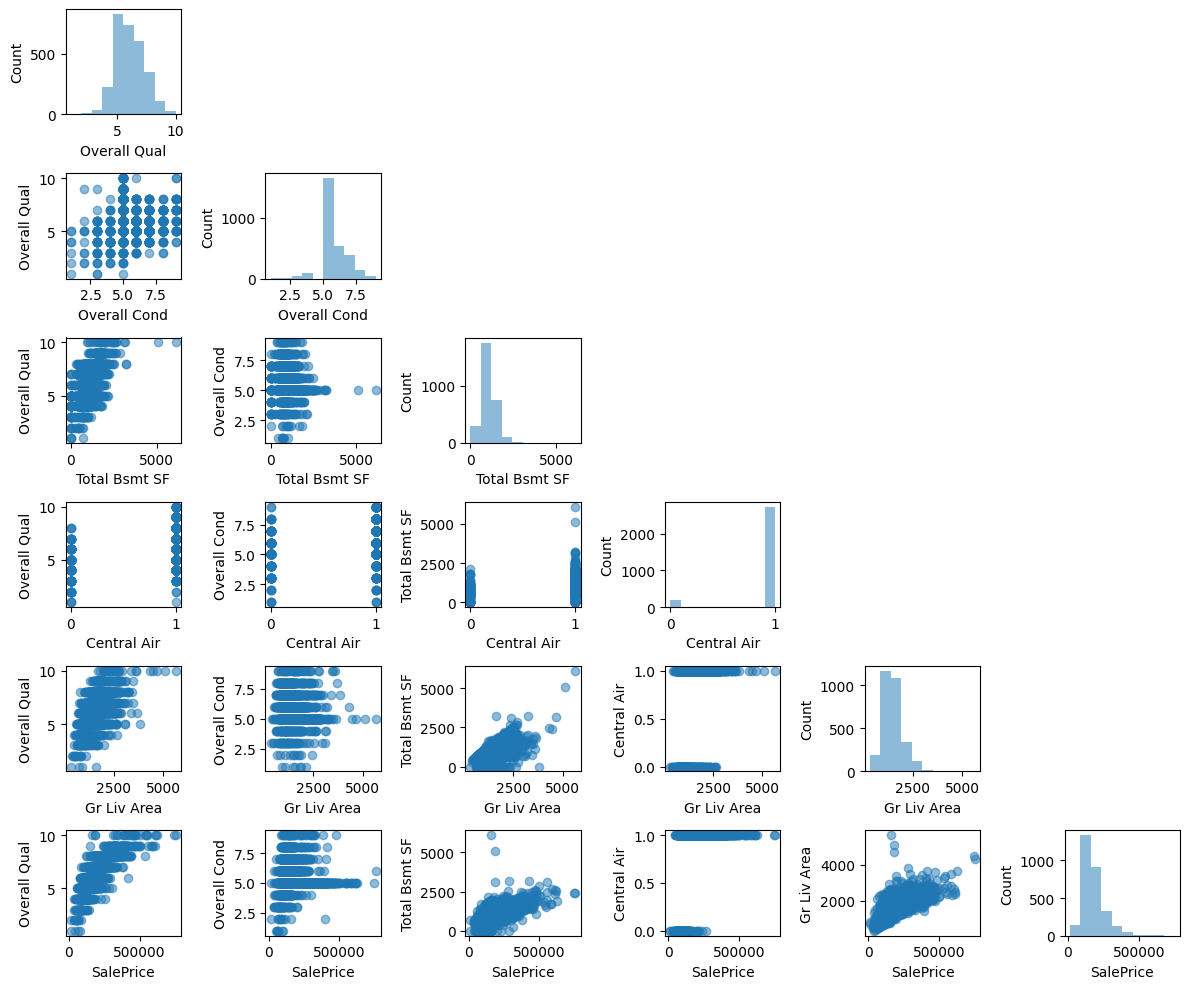

In [ ]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

scatterplotmatrix(df.values, figsize=(12, 10),
                  names=df.columns, alpha=.5)
plt.tight_layout()
plt.show()

In [ ]:
pip install mlxtend==0.22.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


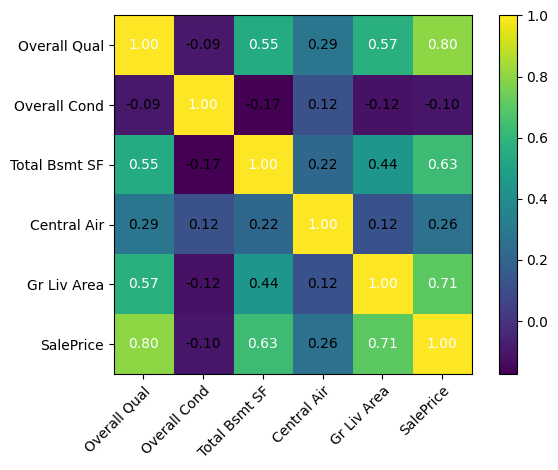

In [ ]:
import numpy as np
from mlxtend.plotting import heatmap

cm = np.corrcoef(df.values.T)
hm = heatmap(cm, row_names=df.columns, column_names=df.columns)
plt.tight_layout()
plt.show()

In [ ]:
class LinearRegressionGD:
  def __init__(self, eta=.01, n_iter=50, random_state=1):
    self.eta = eta
    self.n_iter = n_iter
    self.random_state = random_state

  def fit(self, X, y):
    rgen = np.random.RandomState(self.random_state)
    self.w_ = rgen.normal(loc=.0, scale=.01, size=X.shape[1])
    self.b_ = np.array([0.])
    self.losses_ = []

    for i in range(self.n_iter):
      output = self.net_input(X)
      errors = (y - output)
      self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
      self.b_ += self.eta * 2.0 * errors.mean()
      loss = (errors**2).mean()
      self.losses_.append(loss)

    return self

  def net_input(self, X):
    return np.dot(X, self.w_) + self.b_

  def predict(self, X):
    return self.net_input(X)

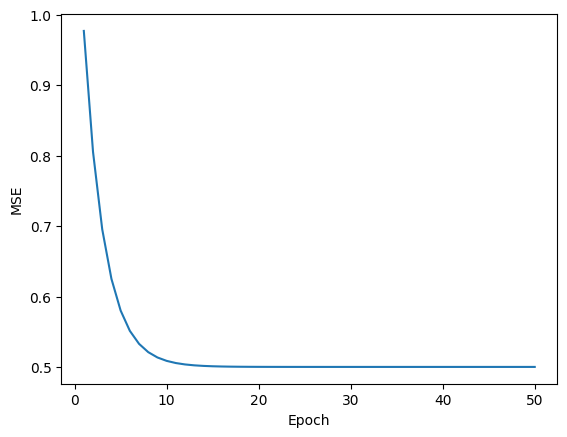

In [ ]:
X = df["Gr Liv Area"].values.reshape(-1, 1)
y = df["SalePrice"].values

from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
lr = LinearRegressionGD(eta=.1)
lr.fit(X_std, y_std)
plt.plot(range(1, lr.n_iter+1), lr.losses_)
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.show()

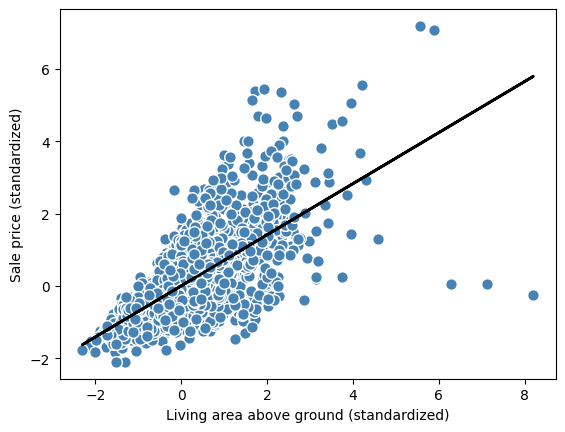

In [ ]:
def lin_regplot(X, y, model):
  plt.scatter(X, y, c="steelblue", edgecolor="white", s=70)
  plt.plot(X, model.predict(X), color="black", lw=2)

lin_regplot(X_std, y_std, lr)
plt.xlabel("Living area above ground (standardized)")
plt.ylabel("Sale price (standardized)")
plt.show()

In [ ]:
feature_std = sc_x.transform(np.array([[25000]]))
target_std = lr.predict(feature_std)
target_reverted = sc_y.inverse_transform(target_std.reshape(-1, 1))
print(f"Sales price: ${target_reverted.flatten()[0]:.2f}")

Sales price: $2804962.85


In [ ]:
print(f"Slope: {lr.w_[0]:.3f}")
print(f"Intercept: {lr.b_[0]:.3f}")

Slope: 0.707
Intercept: -0.000


In [ ]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print(f"Slope: {slr.coef_[0]:.3f}")
print(f"Intercept: {slr.intercept_:.3f}")

Slope: 111.666
Intercept: 13342.979


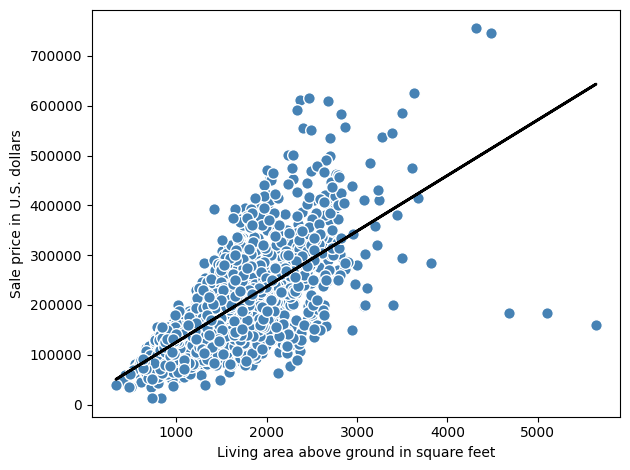

In [ ]:
lin_regplot(X, y, slr)
plt.xlabel("Living area above ground in square feet")
plt.ylabel("Sale price in U.S. dollars")
plt.tight_layout()
plt.show()

As an alternative to throwing out outliers, we will look at a robust method of regression using the
RANdom SAmple Consensus (RANSAC) algorithm, which fits a regression model to a subset of the
data, the so-called inliers.

We can summarize the iterative RANSAC algorithm as follows:
1. Select a random number of examples to be inliers and fit the model.
2. Test all other data points against the fitted model and add those points that fall within a user-given tolerance to the inliers.
3. Refit the model using all inliers.
4. Estimate the error of the fitted model versus the inliers.
5. Terminate the algorithm if the performance meets a certain user-defined threshold or if a
fixed number of iterations was reached; go back to step 1 otherwise.

In [ ]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(
    LinearRegression(),
    max_trials=100, #default value
    min_samples=.95,
    residual_threshold=None, #default value
    random_state=123)
ransac.fit(X, y)
# By default (via residual_threshold=None), scikit-learn uses the MAD estimate to select the inlier
# threshold, where MAD stands for the median absolute deviation of the target values, y.

RANSACRegressor(estimator=LinearRegression(), min_samples=0.95,
                random_state=123)

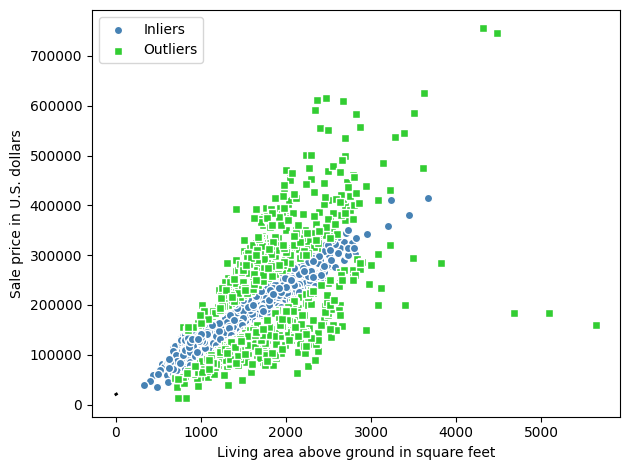

In [ ]:
inlier_mask = ransac.inlier_mask_ #booleans
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c="steelblue", edgecolor="white",
            marker="o", label="Inliers")
plt.scatter(X[outlier_mask], y[outlier_mask],
            c="limegreen", edgecolor="white",
            marker="s", label="Outliers")
plt.plot(line_X, line_y_ransac, color="black", lw=2)
plt.xlabel("Living area above ground in square feet")
plt.ylabel("Sale price in U.S. dollars")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
print(f'Slope: {ransac.estimator_.coef_[0]:.3f}')
print(f'Intercept: {ransac.estimator_.intercept_:.3f}')

Slope: 106.348
Intercept: 20190.093


In [ ]:
def mean_absolute_deviation(data):
  return np.mean(np.abs(data - np.mean(data)))

mean_absolute_deviation(y)

58269.561754979375

**Evaluating the performance of linear regression**

In [ ]:
from sklearn.model_selection import train_test_split

target = "SalePrice"
features = df.columns[df.columns != target]
X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=123)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

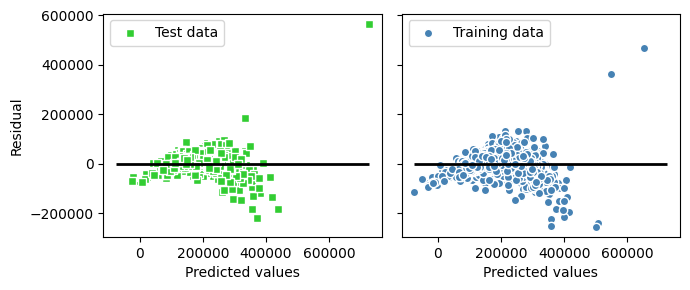

In [ ]:
x_max = np.max(
    [np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min(
    [np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(7, 3), sharey=True)

ax1.scatter(
    y_test_pred, y_test_pred - y_test,
    c="limegreen", marker="s",
    edgecolor="white",
    label="Test data")
ax2.scatter(
    y_train_pred, y_train_pred - y_train,
    c="steelblue", marker="o", edgecolor="white",
    label="Training data")
ax1.set_ylabel("Residual")

for ax in (ax1, ax2):
  ax.set_xlabel("Predicted values")
  ax.legend(loc="upper left")
  ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100,
            color="black", lw=2)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"MSE train: {mse_train:.2f}")
print(f"MSE test: {mse_test:.2f}")

MSE train: 1497216245.85
MSE test: 1516565821.00


In [ ]:
from sklearn.metrics import mean_absolute_error

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"MAE train: {mae_train:.2f}")
print(f"MAE test: {mae_test:.2f}")

MAE train: 25983.03
MAE test: 24921.29


In [ ]:
from sklearn.metrics import r2_score

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"R^2 train: {train_r2:.3f}, test: {test_r2:.3f}")

R^2 train: 0.769, test: 0.752


In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.,)
ridge.fit(X_train, y_train)
y_test_ridge = ridge.predict(X_test)
ridge_test_r2 = r2_score(y_test, y_test_ridge)
print(f"Ridge test socre: {ridge_test_r2:.3f}")

Ridge test socre: 0.752


In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=1.,)
lasso.fit(X_train, y_train)
y_test_lasso = lasso.predict(X_test)
lasso_test_r2 = r2_score(y_test, y_test_lasso)
print(f"Lasso test socre: {lasso_test_r2:.3f}")

Lasso test socre: 0.752


In [ ]:
from sklearn.linear_model import ElasticNet

elanet = ElasticNet(alpha=1., l1_ratio=.5)
elanet.fit(X_train, y_train)
y_test_elanet  = elanet.predict(X_test)
elanet_test_r2 = r2_score(y_test, y_test_elanet)
print(f"ElasticNet test socre: {elanet_test_r2:.3f}")

ElasticNet test socre: 0.727


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

X = np.array([ 258.0, 270.0, 294.0, 320.0, 342.0,
               368.0, 396.0, 446.0, 480.0, 586.0])[:, np.newaxis]
y = np.array([ 236.4, 234.4, 252.8, 298.6, 314.2,
               342.2, 360.8, 368.0, 391.2, 390.8])

lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2) # giren sayı 5 olsun. Çıktı = 1 5 25
X_quad = quadratic.fit_transform(X)

In [ ]:
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

In [ ]:
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

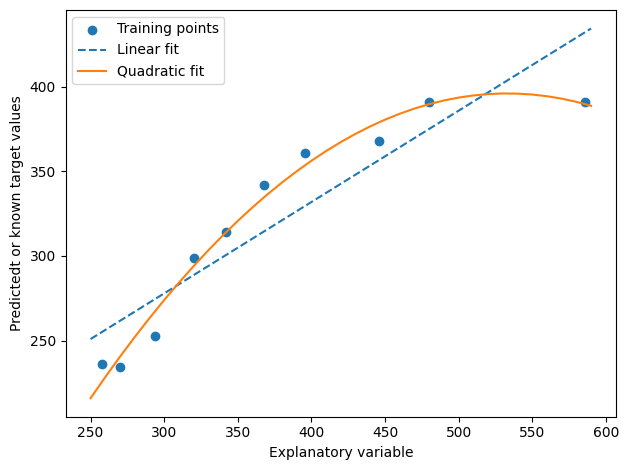

In [ ]:
plt.scatter(X, y, label="Training points")
plt.plot(X_fit, y_lin_fit,
         label="Linear fit", linestyle="--")
plt.plot(X_fit, y_quad_fit,
         label="Quadratic fit")
plt.xlabel("Explanatory variable")
plt.ylabel("Predictedt or known target values")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
mse_lin = mean_squared_error(y, y_lin_pred)
mse_quad = mean_squared_error(y, y_quad_pred)
print(f"Training MSE linear: {mse_lin:.3f};"
      f" quadratic: {mse_quad:.3f}")
r2_lin = r2_score(y, y_lin_pred)
r2_quad = r2_score(y, y_quad_pred)
print(f"Training R^2 linear: {r2_lin:.3f};"
      f" quadratic: {r2_quad:.3f}")

Training MSE linear: 569.780; quadratic: 61.330
Training R^2 linear: 0.832; quadratic: 0.982


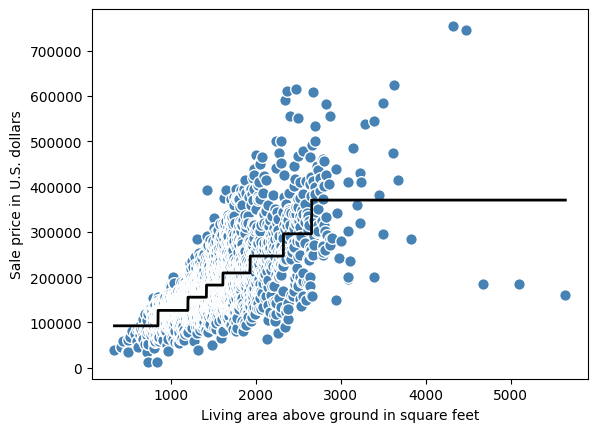

In [ ]:
from sklearn.tree import DecisionTreeRegressor

X = df["Gr Liv Area"].values.reshape(-1, 1)
y = df["SalePrice"].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel("Living area above ground in square feet")
plt.ylabel("Sale price in U.S. dollars")
plt.show()